In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.preprocessing import StandardScaler
from models.CR import CR3D
from models.CRJ import CRJ3D
from models.MCI import MCI3D
from models.ESN import ESN3D
from models.SAR import SAR3D
from models.SparseESN import SparseESN3D
from models.SW import SW3DSegregated, SW3DRandom
from models.HFR import HFRRes3D
from models.MC import MicrocolumnRes3D
from metrics.metrics import mse_dimwise, nrmse_dimwise, compute_valid_prediction_time, compute_attractor_deviation, compute_relative_psd

In [2]:
def lorenz_deriv(state, t, sigma=10.0, rho=28.0, beta=8.0/3.0):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x*(rho - z) - y
    dzdt = x*y - beta*z
    return [dxdt, dydt, dzdt]

def generate_lorenz_data(
    initial_state=[1.0, 1.0, 1.0],
    tmax=25.0,
    dt=0.01,
    sigma=10.0,
    rho=28.0,
    beta=8.0/3.0
):
    num_steps = int(tmax / dt) + 1 # +1 to include t=0
    t_vals = np.linspace(0, tmax, num_steps)
    sol = odeint(lorenz_deriv, initial_state, t_vals, args=(sigma, rho, beta))
    return t_vals, sol

In [ ]:
def compute_valid_prediction_time(y_true, y_pred, t_vals, threshold, lambda_max, dt):
    """
    Compute the Valid Prediction Time (VPT) and compare it to Lyapunov time T_lambda = 1 / lambda_max.
    
    Parameters
    ----------
    y_true : ndarray of shape (N, dim)
        True trajectory over time.
    y_pred : ndarray of shape (N, dim)
        Model's predicted trajectory over time (closed-loop).
    t_vals : ndarray of shape (N,)
        Time values corresponding to the trajectory steps.
    threshold : float, optional
        The error threshold, default is 0.4 as in your snippet.
    lambda_max : float, optional
        Largest Lyapunov exponent. Default=0.9 for Lorenz.
        
    Returns
    -------
    T_VPT : float
        Valid prediction time. The earliest time at which normalized error surpasses threshold
        (or the last time if never surpassed).
    T_lambda : float
        Lyapunov time = 1 / lambda_max
    ratio : float
        How many Lyapunov times the model prediction remains valid, i.e. T_VPT / T_lambda.
    """
    # 1) Average of y_true
    y_mean = np.mean(y_true, axis=0)  # shape (dim,)
    
    # 2) Time-averaged norm^2 of (y_true - y_mean)
    y_centered = y_true - y_mean
    denom = np.mean(np.sum(y_centered**2, axis=1))  # scalar
    
    # 3) Compute the normalized error delta_gamma(t) = ||y_true - y_pred||^2 / denom
    diff = y_true - y_pred
    err_sq = np.sum(diff**2, axis=1)  # shape (N,)
    delta_gamma = err_sq / denom      # shape (N,)
    
    # 4) Find the first time index where delta_gamma(t) exceeds threshold
    idx_exceed = np.where(delta_gamma > threshold)[0]
    if len(idx_exceed) == 0:
        # never exceeds threshold => set T_VPT to the final time
        T_VPT = t_vals[-1]
    else:
        T_VPT = t_vals[idx_exceed[0]]
    
    # 5) Compute T_lambda and ratio
    T_lambda = 1.0 / lambda_max

    # print(f"\n--- Valid Prediction Time (VPT) with threshold={threshold}, lambda_max={lambda_max} ---")

    T_VPT = (T_VPT - t_vals[0])  # Adjust T_VPT to be relative to the start time
    ratio = T_VPT / T_lambda

    return T_VPT, T_lambda, ratio

In [4]:
def report_vpt(name, preds, test_target, time_test, dt):
    T_VPT, T_lambda, ratio = compute_valid_prediction_time(
        test_target, preds, time_test, threshold=0.4, lambda_max=0.9, dt=dt
    )
    print(f"{name:20s} => T_VPT={T_VPT:.3f},  T_lambda={T_lambda:.3f}, ratio={ratio:.3f}")

In [5]:
# 1) Generate Lorenz data
tmax = 250
dt   = 0.02
t_vals, lorenz_traj = generate_lorenz_data(
    initial_state=[1.0,1.0,1.0],
    tmax=tmax,
    dt=dt
)

washout = 2000
t_vals = t_vals[washout:]
lorenz_traj = lorenz_traj[washout:]

# normalize
scaler = StandardScaler()
scaler.fit(lorenz_traj)
lorenz_traj = scaler.transform(lorenz_traj)

T_data = len(lorenz_traj)
print(f"Data length: {T_data}, from t=0..{tmax} with dt={dt}.")

n_test_steps = 2100

# train/test split
train_frac = 0.8
train_end = int(train_frac*(T_data-1))
train_input  = lorenz_traj[:train_end]
train_target = lorenz_traj[1:train_end+1]
test_input   = lorenz_traj[train_end:train_end+n_test_steps]
test_target  = lorenz_traj[train_end+1:train_end+n_test_steps+1]
print(f"Train size: {len(train_input)}  Test size: {len(test_input)}")

initial_in = test_input[0]

Data length: 10501, from t=0..250 with dt=0.02.
Train size: 8400  Test size: 2100


In [15]:
# (a) Baseline ESN
esn = ESN3D(
    reservoir_size=300,
    spectral_radius=0.95,
    input_scale=0.2,
    leaking_rate=0.4,
    ridge_alpha=1e-06,
    seed=42
)
esn.fit_readout(train_input, train_target, discard=100)

# (b) Cycle Reservoir
cycle_res = CR3D(
    reservoir_size=300,
    spectral_radius=0.8,
    input_scale=0.2,
    leaking_rate=0.4,
    ridge_alpha=1.00E-06,
    seed=43
)
cycle_res.fit_readout(train_input, train_target, discard=100)

# (c) Sparse ESN
sparse_res = SparseESN3D(
    reservoir_size=300,
    spectral_radius=0.8,
    connectivity=0.04,
    input_scale=0.3,
    leaking_rate=0.4,
    ridge_alpha=1.00E-06,
    seed=44
)
sparse_res.fit_readout(train_input, train_target, discard=100)

# # (d) Self-Attention Reservoir (SAR)
# sar = SAR3D(
#     reservoir_size=300,
#     embedding_dim=16, # increasing dim would perhaps lead to better performance though at the cost of compute (32 seems to be optimal)
#     spectral_radius=0.95,   # set base adjacency effectively 0
#     input_scale=1.0,
#     leaking_rate=0.8,
#     ridge_alpha=1e-6,
#     seed=45
# )
# sar.fit_readout(train_input, train_target, discard=100)

# (e) Cycle Reservoir with Jumps (CRJ)
crj = CRJ3D(
    reservoir_size=300,
    jump=15,                # offset for the jump
    spectral_radius=1,
    input_scale=0.4,
    leaking_rate=0.8,
    ridge_alpha=1e-07,
    seed=46
)
crj.fit_readout(train_input, train_target, discard=100)

# (f) Minimal Complexity Interaction (MCI)
mci = MCI3D(
    reservoir_size=300,
    cycle_weight=0.6,      # 'l' in the paper
    connect_weight=0.8,    # 'g' in the paper
    input_scale=0.4,
    leaking_rate=0.4,
    ridge_alpha=1.00E-06,
    combine_factor=0.7,    # 'h' in the paper
    seed=47,
    v1=0.4, v2=0.4         # 'v1' and 'v2' in the paper
)
mci.fit_readout(train_input, train_target, discard=100)

# Small World Segregated
sws = SW3DSegregated(
    reservoir_size=300,
    edges_per_node=6,            # Must be even (here 6: 3 forward, 3 backward)
    input_reservoir_size=100,      # Number of input nodes
    output_reservoir_size=100,     # Number of output nodes
    rewiring_probability=0.83,
    spectral_radius=0.95,
    input_scale=0.46,
    leaking_rate=1.0,
    ridge_alpha=1e-7,
    seed=48
)
sws.fit_readout(train_input, train_target, discard=100)

# Small World Random
swr = SW3DRandom(
    reservoir_size=300,
    edges_per_node=6,              # Must be even (here: 3 neighbors forward, 3 backward)
    input_reservoir_size=100,        # Number of input nodes
    output_reservoir_size=100,       # Number of output nodes
    rewiring_probability=0.1,
    spectral_radius=0.98,
    input_scale=0.235,
    leaking_rate=1.0,
    ridge_alpha=1e-7,
    seed=49
)
swr.fit_readout(train_input, train_target, discard=100)

# (g) Hierarchical Fractal Reservoir (HFR)
hfr_res = HFRRes3D(
    n_levels=2,             # number of hierarchical scales
    cells_per_level=[20, 320],   #[32, 32, 32, 32, 32, 32, 32, 32, 64],   # number of partitions at each scale (sum => total reservoir size) 
                                                        # this config gave 11 VPT: 32, 32, 32, 32, 32, 32, 32, 32, 32, 64, 64, 64
                                                        # this config gave 10.62 VPT: 32, 32, 32, 32, 32, 32, 32, 32, 32, 32
                                                        # clubbing two of them let to a drop to 10.0 VPT: 32, 32, 32, 32, 32, 32, 32, 32, 64 
                                                        # but funny part is that 320 itself is giving 12.06 VPT
    spectral_radius=0.95,
    input_scale=0.2,
    leaking_rate=0.1,
    ridge_alpha=1e-8,
    seed=50
)
hfr_res.fit_readout(train_input, train_target, discard=100)

# (h) Microcolumn Reservoir (MC)
micro_res= MicrocolumnRes3D(
        n_columns=50, # reservoir size N=(units per column)×(number of columns) = (4+1)×50
        n_excit=5,
        n_inhib=1, # 1 seems like most effective, 0 kills it
        spectral_radius=0.97, # highest performance recorded around 0.97, 0.98
        input_scale=0.2,
        leaking_rate=0.3,
        ridge_alpha=1e-6,
        prob_inter=0.03,
        seed=123
    )
micro_res.fit_readout(train_input, train_target, discard=100)

c:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [16]:
esn_preds    = esn.predict_autoregressive(initial_in, n_test_steps)
cycle_preds  = cycle_res.predict_autoregressive(initial_in, n_test_steps)
sparse_preds = sparse_res.predict_autoregressive(initial_in, n_test_steps)
# sar_preds    = sar.predict_autoregressive(initial_in, n_test_steps)
crj_preds = crj.predict_autoregressive(initial_in, n_test_steps)
mci_preds = mci.predict_autoregressive(initial_in, n_test_steps)
sws_preds = sws.predict_autoregressive(initial_in, n_test_steps)
swr_preds = swr.predict_autoregressive(initial_in, n_test_steps)
hfr_preds = hfr_res.predict_autoregressive(initial_in, n_test_steps)
mc_preds = micro_res.predict_autoregressive(initial_in, n_test_steps)

In [17]:
# esn_preds = esn.predict_open_loop(test_input=test_input)
# cycle_preds = cycle_res.predict_open_loop(test_input=test_input)
# sparse_preds = sparse_res.predict_open_loop(test_input=test_input)
# # sar_preds = sar.predict_open_loop(test_input=test_input)
# crj_preds = crj.predict_open_loop(test_input=test_input)
# mci_preds = mci.predict_open_loop(test_input=test_input)
# sws_preds = sws.predict_open(test_input=test_input)
# swr_preds = swr.predict_open(test_input=test_input)


--- Valid Prediction Time (VPT) with threshold=0.4, lambda_max=0.9 ---
Dense ESN            => T_VPT=8.920,  T_lambda=1.111, ratio=8.028

--- Valid Prediction Time (VPT) with threshold=0.4, lambda_max=0.9 ---
Cycle Res            => T_VPT=9.700,  T_lambda=1.111, ratio=8.730

--- Valid Prediction Time (VPT) with threshold=0.4, lambda_max=0.9 ---
Sparse ESN           => T_VPT=9.600,  T_lambda=1.111, ratio=8.640

--- Valid Prediction Time (VPT) with threshold=0.4, lambda_max=0.9 ---
CRJ                  => T_VPT=7.420,  T_lambda=1.111, ratio=6.678

--- Valid Prediction Time (VPT) with threshold=0.4, lambda_max=0.9 ---
MCI                  => T_VPT=9.760,  T_lambda=1.111, ratio=8.784

--- Valid Prediction Time (VPT) with threshold=0.4, lambda_max=0.9 ---
SW Segregated        => T_VPT=0.420,  T_lambda=1.111, ratio=0.378

--- Valid Prediction Time (VPT) with threshold=0.4, lambda_max=0.9 ---
SW Random            => T_VPT=0.720,  T_lambda=1.111, ratio=0.648

--- Valid Prediction Time (VPT) w

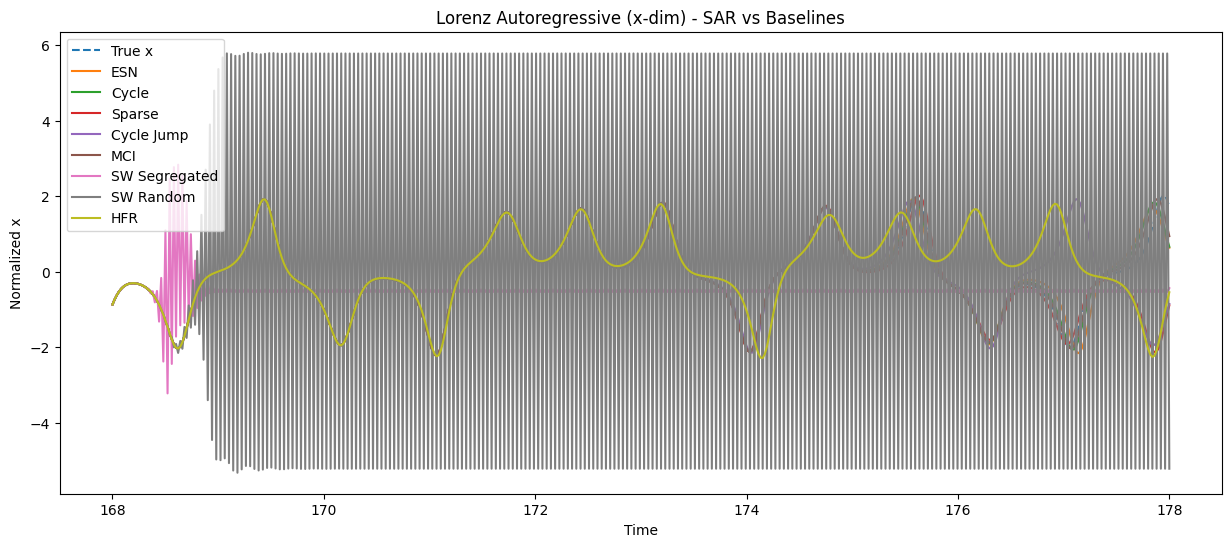

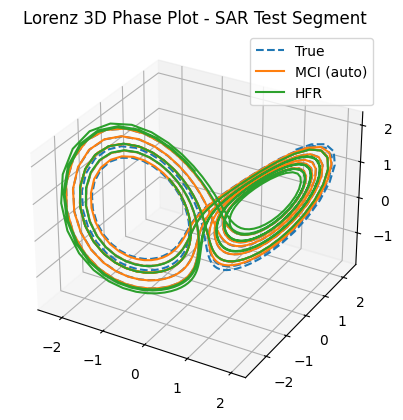

In [18]:
# MSE calculation
mse_esn    = mse_dimwise(esn_preds,    test_target)
mse_cycle  = mse_dimwise(cycle_preds,  test_target)
mse_sparse = mse_dimwise(sparse_preds, test_target)
# mse_sar    = mse_dimwise(sar_preds,    test_target)
mse_crj    = mse_dimwise(crj_preds,    test_target)
mse_mci    = mse_dimwise(mci_preds,    test_target)
mse_sws    = mse_dimwise(sws_preds, test_target)
mse_swr    = mse_dimwise(swr_preds, test_target)
mse_hfr    = mse_dimwise(hfr_preds,    test_target)

# NRMSE calculation
nrmse_esn    = nrmse_dimwise(esn_preds,    test_target)
nrmse_cycle  = nrmse_dimwise(cycle_preds,  test_target)
nrmse_sparse = nrmse_dimwise(sparse_preds, test_target)
# nrmse_sar    = nrmse_dimwise(sar_preds,    test_target)
nrmse_crj    = nrmse_dimwise(crj_preds,    test_target)
nrmse_mci    = nrmse_dimwise(mci_preds,    test_target)
nrmse_sws    = nrmse_dimwise(sws_preds, test_target)
nrmse_swr    = nrmse_dimwise(swr_preds, test_target)
nrmse_hfr    = nrmse_dimwise(hfr_preds,    test_target)

# VPT calculation
report_vpt("Dense ESN",    esn_preds, test_target, t_vals[train_end:train_end+n_test_steps], dt)
report_vpt("Cycle Res",  cycle_preds, test_target, t_vals[train_end:train_end+n_test_steps], dt)
report_vpt("Sparse ESN",   sparse_preds, test_target, t_vals[train_end:train_end+n_test_steps], dt)
# report_vpt("SelfAttention", sar_preds, test_target, t_vals[train_end:train_end+n_test_steps], dt)
report_vpt("CRJ",         crj_preds, test_target, t_vals[train_end:train_end+n_test_steps], dt)
report_vpt("MCI",         mci_preds, test_target, t_vals[train_end:train_end+n_test_steps], dt)
report_vpt("SW Segregated",   sws_preds,     test_target, t_vals[train_end:train_end+n_test_steps], dt)
report_vpt("SW Random", swr_preds, test_target, t_vals[train_end:train_end+n_test_steps], dt)
report_vpt("HFR",         hfr_preds, test_target, t_vals[train_end:train_end+n_test_steps], dt)
# report_vpt("MC",         mc_preds, test_target, t_vals[train_end:train_end+n_test_steps], dt)

# Attractor Deviation calculation
adev_esn = compute_attractor_deviation(esn_preds, test_target)
adev_cycle = compute_attractor_deviation(cycle_preds, test_target)
adev_sparse = compute_attractor_deviation(sparse_preds, test_target)
# adev_sar = compute_attractor_deviation(sar_preds, test_target)
adev_crj = compute_attractor_deviation(crj_preds, test_target)
adev_mci = compute_attractor_deviation(mci_preds, test_target)
adev_sws = compute_attractor_deviation(sws_preds, test_target)
adev_swr = compute_attractor_deviation(swr_preds, test_target)
adev_hfr = compute_attractor_deviation(hfr_preds, test_target)

# Relative PSD calculation
rel_psd_esn = compute_relative_psd(test_target, esn_preds)
rel_psd_cycle = compute_relative_psd(test_target, cycle_preds)
rel_psd_sparse = compute_relative_psd(test_target, sparse_preds)
# rel_psd_sar = compute_relative_psd(test_target, sar_preds)
rel_psd_crj = compute_relative_psd(test_target, crj_preds)
rel_psd_mci = compute_relative_psd(test_target, mci_preds)
rel_psd_sws = compute_relative_psd(test_target, sws_preds)
rel_psd_swr = compute_relative_psd(test_target, swr_preds)
rel_psd_hfr = compute_relative_psd(test_target, hfr_preds)

# 4) Print results
print("\n--- Relative PSD ---")
print("Dense ESN    :",  rel_psd_esn)
print("Cycle Res    :",  rel_psd_cycle)
print("Sparse ESN   :",  rel_psd_sparse)
# print("SelfAttention:",  rel_psd_sar)
print("Cycle + Jump :",  rel_psd_crj)
print("Minimal Comp :",  rel_psd_mci)
print("SW Segregated:",  rel_psd_sws)
print("SW Random    :",  rel_psd_swr)
print("HFR           :",  rel_psd_hfr)

print("\n--- Attractor Deviation ---")
print("Dense ESN    :",  adev_esn)
print("Cycle Res    :",  adev_cycle)
print("Sparse ESN   :",  adev_sparse)
# print("SelfAttention:",  adev_sar)
print("Cycle + Jump :",  adev_crj)
print("Minimal Comp :",  adev_mci)
print("SW Segregated:",  adev_sws)
print("SW Random    :",  adev_swr)
print("HFR          :",  adev_hfr)

print("\n--- Multi-step Autoregressive MSE ---")
print("Dense ESN    :",  mse_esn)
print("Cycle Res    :",  mse_cycle)
print("Sparse ESN   :",  mse_sparse)
# print("SelfAttention:",  mse_sar)
print("Cycle + Jump :",  mse_crj)
print("Minimal Comp :",  mse_mci) 
print("SW Segregated:",  mse_sws)
print("SW Random    :",  mse_swr)
print("HFR          :",  mse_hfr)

print("\n--- Multi-step Autoregressive NRMSE ---")
print("Dense ESN    :",  nrmse_esn)
print("Cycle Res    :",  nrmse_cycle)
print("Sparse ESN   :",  nrmse_sparse)
# print("SelfAttention:",  nrmse_sar)
print("Cycle + Jump :",  nrmse_crj)
print("Minimal Comp :",  nrmse_mci)
print("SW Segregated:",  nrmse_sws)
print("SW Random    :",  nrmse_swr)
print("HFR          :",  nrmse_hfr)

# 4) partial trajectory
plot_len = min(500, n_test_steps)
time_test = np.linspace(train_end*dt, (train_end+plot_len)*dt, plot_len)

plt.figure(figsize=(15,6))
plt.plot(time_test, test_target[:plot_len,0], label='True x', linestyle='--')
plt.plot(time_test, esn_preds[:plot_len,0],    label='ESN')
plt.plot(time_test, cycle_preds[:plot_len,0],  label='Cycle')
plt.plot(time_test, sparse_preds[:plot_len,0], label='Sparse')
# plt.plot(time_test, sar_preds[:plot_len,0],    label='SAR')
plt.plot(time_test, crj_preds[:plot_len,0],    label='Cycle Jump')
plt.plot(time_test, mci_preds[:plot_len,0],    label='MCI')
plt.plot(time_test, sws_preds[:plot_len,0],     label='SW Segregated')
plt.plot(time_test, swr_preds[:plot_len,0], label='SW Random')
plt.plot(time_test, hfr_preds[:plot_len,0],    label='HFR')

plt.title('Lorenz Autoregressive (x-dim) - SAR vs Baselines')
plt.xlabel('Time')
plt.ylabel('Normalized x')
plt.legend()
plt.show()

# 3D plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(test_target[:plot_len,0], test_target[:plot_len,1], test_target[:plot_len,2],
        label='True', linestyle='--')
# ax.plot(sar_preds[:plot_len,0], sar_preds[:plot_len,1], sar_preds[:plot_len,2],
#         label='SAR (auto)')
ax.plot(mci_preds[:plot_len,0], mci_preds[:plot_len,1], mci_preds[:plot_len,2],
        label='MCI (auto)')
ax.plot(hfr_preds[:plot_len,0], hfr_preds[:plot_len,1], hfr_preds[:plot_len,2],
        label='HFR')
ax.set_title('Lorenz 3D Phase Plot - SAR Test Segment')
ax.legend()
plt.show()